### Generating sequences
To be able to train neural networks on sequential data, you need to pre-process it first. You'll chunk the data into inputs-target pairs, where the inputs are some number of consecutive data points and the target is the next data point.

Your task is to define a function to do this called create_sequences(). As inputs, it will receive data stored in a DataFrame, df and seq_length, the length of the inputs. As outputs, it should return two NumPy arrays, one with input sequences and the other one with the corresponding targets.

In [1]:
import numpy as np

def create_sequences(df, seq_length):
    xs, ys = [], []
    # Iterate over data indices
    for i in range(len(df)-seq_length ):
      	# Define inputs
        x = df.iloc[i:i+seq_length, 1]
        # Define target
        y = df.iloc[i+seq_length, 1]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [32]:
import torch, pandas as pd
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import torchmetrics

In [10]:
train_data = pd.read_csv('../data/electricity_consump/electricity_train.csv')

In [12]:
x_train, y_train = create_sequences(train_data, 24*4)
print(x_train, y_train)

[[-0.70431852 -0.70431852 -0.67898263 ... -0.65364675 -0.72990776
  -0.70431852]
 [-0.70431852 -0.67898263 -0.65364675 ... -0.72990776 -0.70431852
  -0.70431852]
 [-0.67898263 -0.65364675 -0.70431852 ... -0.70431852 -0.70431852
  -0.70431852]
 ...
 [ 0.79759271  0.82292859  0.84826447 ... -0.93259484 -0.93259484
  -0.90725895]
 [ 0.82292859  0.84826447  0.77200346 ... -0.93259484 -0.90725895
  -0.93259484]
 [ 0.84826447  0.77200346  0.72133169 ... -0.90725895 -0.93259484
  -0.93259484]] [-0.70431852 -0.70431852 -0.65364675 ... -0.93259484 -0.93259484
 -0.93259484]


In [13]:
dataset_train = TensorDataset(torch.from_numpy(x_train).float(), torch.from_numpy(y_train).float()) #why we need to convert to float
print(len(dataset_train))

105119


- [ ] Why do we need to convert the tensor to float

### Sequential architectures

Whenever you face a task that requires handling sequential data, you need to be able to decide what type of recurrent architecture is the most suitable for the job. Let's test your understanding of when each architecture is applicable.

The following graphic with the four recurrent architectures might come in handy!

![Architectures](https://assets.datacamp.com/production/repositories/6312/datasets/155ceb431c790a28c6ae64640bcde881ea96a6b2/all_rnn_archs_notext.png)

(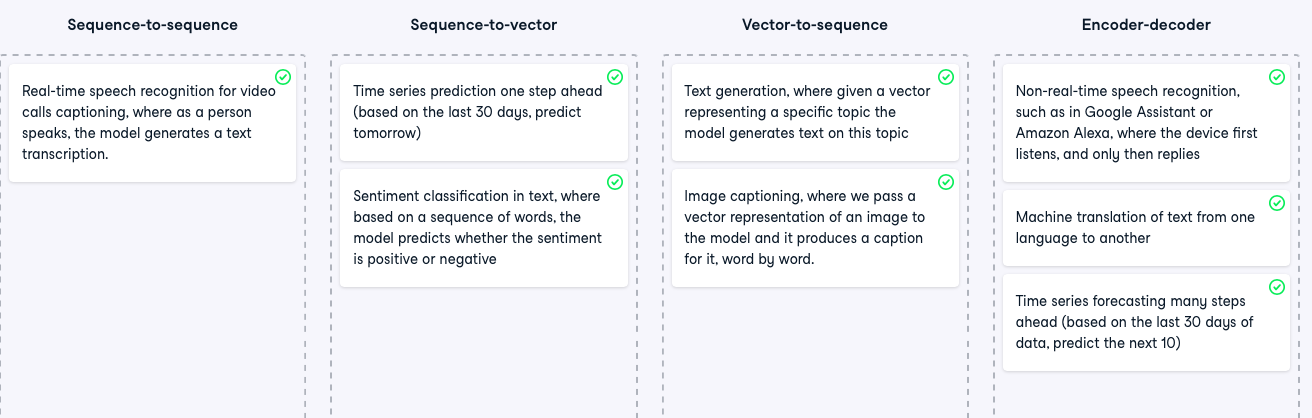)

### Building a forecasting RNN
It's time to build your first recurrent network! It will be a sequence-to-vector model consisting of an RNN layer with two layers and a hidden_size of 32. After the RNN layer, a simple linear layer will map the outputs to a single value to be predicted.

In [14]:
import torch 
import torch.nn as nn

In [20]:
class RNNNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Define RNN layer
        self.rnn = nn.RNN(
            input_size=1,
            hidden_size=32,
            num_layers=2,
            batch_first=True,
        )
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        # Initialize first hidden state with zeros
        h0 = torch.zeros(2, x.size(0), 32)
        # Pass x and h0 through recurrent layer
        out, _ = self.rnn(x, h0)  
        # Pass recurrent layer's last output through linear layer
        out = self.fc(out[:, -1, :])
        return out

### RNN vs LSTSM vs GRU

Understanding the differences between a plain RNN, LSTM, and GRU networks, including their complexity and computation needs, allows you to choose the appropriate one for your task.

![comparision](https://assets.datacamp.com/production/repositories/6312/datasets/a81c7537062b1daec009ad86b2613c065271add0/lstm_and_gru_cells.png)

### LSTM network

In [21]:
class LSTMNet(nn.Module):

    def __init__(self, input_size):
        super.__init__()

        self.lstm = nn.LSTM(
            input_size= input_size,
            hidden_size= 32,
            num_layers=2,
            batch_first=True
        )

        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), 32)
        c0 = torch.zeros(2, x.size(0), 32)
        out, _ = self.lstm(x, (h0,c0))
        out = self.fc(out[:, -1, :])
        return out


- [ ] What does hidden size represent
- [ ] What does num_layes represent
- [ ] Why we take the -1 from the out 

### GRU 

In [22]:
class GRUNet(nn.Module):

    def __init__(self, input_size):
        super.__init__()

        self.lstm = nn.GRU(
            input_size= input_size,
            hidden_size= 32,
            num_layers=2,
            batch_first=True
        )

        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), 32)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

### Training RNN

In [23]:
net = RNNNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [29]:
dataloader_train = DataLoader(dataset_train, batch_size=16, shuffle=True)

In [30]:
for epoch in range(3):
    for seqs, labels in dataloader_train:
        seqs = seqs.view(16, 96, 1)
        outputs = net(seqs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss:{loss.item()}")

/Users/rajaramkankipati/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: shape '[16, 96, 1]' is invalid for input of size 1440

### Evaluating forecasting models
It's evaluation time! The same LSTM network that you have trained in the previous exercise has been trained for you for a few more epochs and is available as net.

Your task is to evaluate it on a test dataset using the Mean Squared Error metric (torchmetrics has already been imported for you). Let's see how well the model is doing!

In [33]:
mse = torchmetrics.MeanSquaredError()

In [34]:
net.eval()

RNNNet(
  (rnn): RNN(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [36]:
test_data = pd.read_csv('../data/electricity_consump/electricity_test.csv')

In [37]:
x_test, y_test = create_sequences(test_data, seq_length=24*4)

In [38]:
dataset_test = TensorDataset(torch.from_numpy(x_test).float(), torch.from_numpy(y_test).float())

In [39]:
dataloader_test = DataLoader(dataset_test, batch_size=16, shuffle=True)

In [40]:
with torch.no_grad():
    for seqs, labels in dataloader_test:
        seqs = seqs.view(16, 96, 1)
        outputs = net(seqs).squeeze()
        mse(outputs, labels)
test_mse = mse.compute() 
print(f"Test MSE: {test_mse}")

Test MSE: 0.5896291136741638
